In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import r2_score

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
df = pd.read_parquet("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/FE30Stocks.parquet")

In [4]:
feats = ['stock_id', 'mid_price', 'spread', 'imbalance',
       'book_pressure', 'LOB_entropy', 'log_return', 'bipower_var',
       'log_wap_return', 'imbalance_lag1', 'imbalance_lag2',
       'book_pressure_lag1', 'book_pressure_lag2', 'log_return_lag1',
       'log_return_lag2', 'rolling_vol_30', 'rolling_imbalance_mean_30',
       'sec_sin', 'sec_cos', 'bid_size1_log', 'ask_size1_log', 'bid_size2_log',
       'ask_size2_log']
target_col = "rv_future"

df['rv_future_log'] = np.log1p(df[target_col])

In [5]:
X = df[feats].values.astype(np.float32)
y = df["rv_future_log"].values.astype(np.float32)

In [6]:
time_ids = df["time_id"].values
blocks = np.unique(time_ids)
block_idx = {b: i for i, b in enumerate(blocks)}
block_indices = np.array([block_idx[t] for t in time_ids])

In [7]:
n_test_blocks = max(int(0.1 * len(blocks)), 1)
block_cv = TimeSeriesSplit(n_splits=5, test_size=n_test_blocks, gap=1)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_rmse = float("inf")
best_state = None
best_scaler = None

In [9]:
class ANN_ARCH(nn.Module):
    def __init__(self, n_in: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [10]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(np.log(np.clip(y, a_min=1e-8, a_max=None))).float()

In [ ]:
for fold, (train_block_idxs, val_block_idxs) in enumerate(block_cv.split(blocks), 1):
    train_mask = np.isin(block_indices, train_block_idxs)
    val_mask   = np.isin(block_indices, val_block_idxs)
    train_idx = np.where(train_mask)[0]
    val_idx   = np.where(val_mask)[0]

    scaler = StandardScaler().fit(X[train_idx])
    X_train = scaler.transform(X[train_idx])
    X_val   = scaler.transform(X[val_idx])

    X_train_t = torch.from_numpy(X_train).to(device)
    y_train_t = y_tensor[train_idx].to(device)
    X_val_t   = torch.from_numpy(X_val).to(device)
    y_val_t   = y_tensor[val_idx].to(device)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False)

    model = ANN_ARCH(n_in=X.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(10): 
        print(f"Epoch: {epoch}")
        model.train()
        for xb, yb in train_loader:
            opt.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            if not torch.isnan(loss):
                loss.backward()
                opt.step()

    model.eval()
    with torch.no_grad():
        preds = torch.cat([model(xb).cpu() for xb, _ in val_loader]).squeeze()
    rmse = torch.sqrt(((preds - y_val_t.cpu()) ** 2).mean())

    print(f"Fold {fold}: val RMSE (log-σ) = {rmse:.4f}\n")
    if rmse < best_rmse:
        best_rmse = rmse
        best_state = model.state_dict()
        best_scaler = scaler

In [ ]:
scaler_full = StandardScaler().fit(X)
X_full = scaler_full.transform(X)
X_full_t = torch.from_numpy(X_full).to(device)
y_full_t = y_tensor.to(device)

full_ds = TensorDataset(X_full_t, y_full_t)
full_loader = DataLoader(full_ds, batch_size=1024, shuffle=True)

final_model = ANN_ARCH(n_in=X.shape[1]).to(device)
final_model.load_state_dict(best_state)
opt = torch.optim.Adam(final_model.parameters(), lr=1e-3)

In [ ]:
final_model.train()
for epoch in range(50): 
    print(f"Epoch: {epoch}")
    for xb, yb in full_loader:
        opt.zero_grad()
        preds = final_model(xb).squeeze()
        loss = loss_fn(preds, yb)
        if not torch.isnan(loss):
            loss.backward()
            opt.step()

print(f"Best validation RMSE (log-σ) across folds = {best_rmse:.4f}")

Best validation RMSE (log-σ) across folds = 0.6133


In [ ]:
final_model.eval()
with torch.no_grad():
    x_last = torch.from_numpy(
        scaler_full.transform(X[-1:].astype(np.float32))
    ).to(device)
    log_sigma = final_model(x_last).item()
    sigma = np.exp(log_sigma)  # final output

print(f"Forecast σ (future volatility) = {sigma:.9f}")

Forecast σ (future volatility) = 0.000372324


In [ ]:
test_blocks = max(int(0.05 * len(X)), 1)
X_test  = best_scaler.transform(X[-test_blocks:])
y_test  = y[-test_blocks:]
log_y_test = np.log(np.clip(y_test, a_min=1e-8, a_max=None))

with torch.no_grad():
    X_tensor = torch.tensor(X_test).to(device)
    log_pred = final_model(X_tensor).cpu().numpy().ravel()

y_pred_sigma  = np.exp(log_pred)
y_true_sigma  = np.exp(log_y_test)

In [ ]:
r2 = r2_score(y_true_sigma, y_pred_sigma)
print(f"R² score (σ prediction) = {r2:.6f}")

R² score (σ prediction) = 0.478604


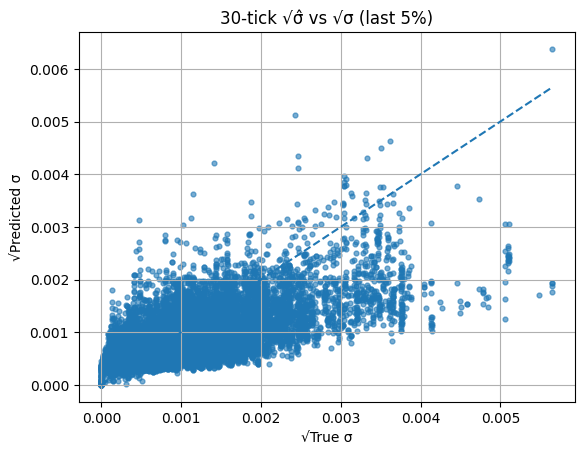

In [ ]:
plt.figure()
plt.scatter(
    y_true_sigma,
    y_pred_sigma,
    s=12,
    alpha=0.6,
)
lims = [0, np.max(y_true_sigma)]
plt.plot(lims, lims, linestyle="--")
plt.title("30-tick √σ̂ vs √σ (last 5%)")
plt.xlabel("√True σ")
plt.ylabel("√Predicted σ")
plt.grid()
plt.show()

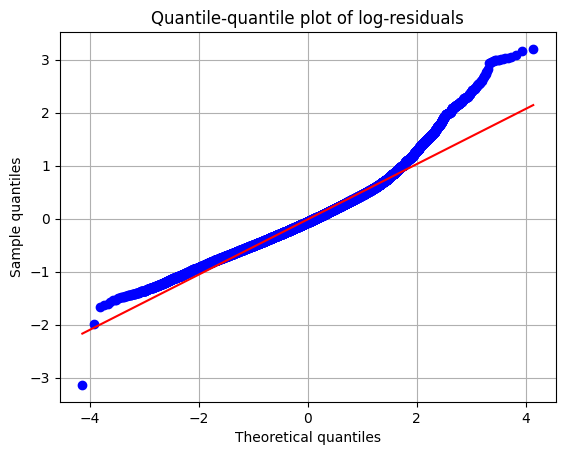

In [ ]:
resid = np.log(y_pred_sigma) - np.log(y_test)
resid = resid[np.isfinite(resid)]

plt.figure()
st.probplot(resid, dist="norm", plot=plt)
plt.title("Quantile-quantile plot of log-residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.grid(True)
plt.show()